In [33]:
import requests
from bs4 import BeautifulSoup
import datetime
import pandas as pd
from tqdm import tqdm
import regex as re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

In [34]:
### read tables from pkl
with open('/Users/euan_brown/Documents/GitHub/NCAA-fh-project/tables.pkl', 'rb') as f:
  data = pickle.load(f)

schedule_table, pbp_table, box_table, player_table = data[0], data[1], data[2], data[3]


In [35]:
box_table[box_table.player_name.str.contains('Kness, Emily')];

In [36]:
box_table[box_table.player_name.str.contains('Sessa, Ashley')];

In [37]:
player_table[player_table.team_name=='North Carolina'];

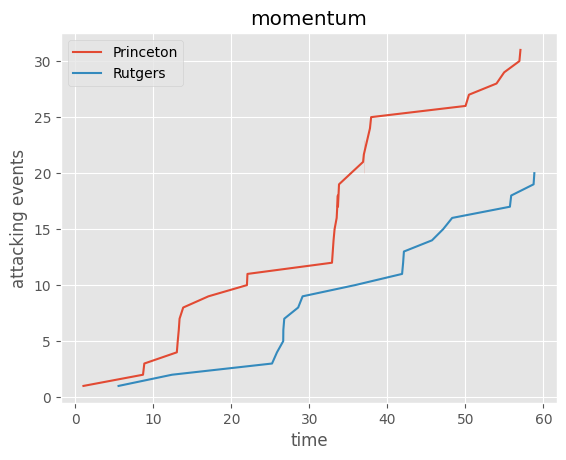

In [38]:
plt.style.use('ggplot')

plot_data = pbp_table[pbp_table['game_ID']==202]
plot_data = plot_data[plot_data['cat_event'].isin(['shot','corner','goal'])]
plot_data = plot_data[['time','home_team_name','away_team_name','home_score','away_score','cat_event','event_team']]
plot_data['pts'] = 1


plot_data_home = plot_data[plot_data['event_team']=='home']
plot_data_away = plot_data[plot_data['event_team']=='away']
plot_data_home['cumsum_pts'] = plot_data_home.pts.cumsum()
plot_data_away['cumsum_pts'] = plot_data_away.pts.cumsum()


fig, ax = plt.subplots()

sns.lineplot(x='time', y='cumsum_pts', data=plot_data_home, ax=ax, label=plot_data_home.home_team_name.unique()[0])
sns.lineplot(x='time', y='cumsum_pts', data=plot_data_away, ax=ax, label=plot_data_away.away_team_name.unique()[0])

ax.set_xlabel('time')
ax.set_ylabel('attacking events')
ax.set_title('momentum')
ax.legend()

plt.show()

In [39]:
# momentum code - very useful

plot_data = pd.concat([plot_data_home,plot_data_away]).sort_values('time')
plot_data['momentum'] = (np.where(plot_data['event_team']=='home',plot_data['pts'],0) - np.where(plot_data['event_team']=='away',plot_data['pts'],0)).cumsum()

In [27]:

def momentumplot(target):

  plt.style.use('seaborn-v0_8-bright')
    
    
  for ID in pbp_table[pbp_table['home_team_name']==target]['game_ID'].unique().tolist() + pbp_table[pbp_table['away_team_name']==target]['game_ID'].unique().tolist():
    
    plot_data = pbp_table[pbp_table['game_ID']==ID]
    plot_data = plot_data[plot_data['cat_event'].isin(['shot','corner','goal'])]
    plot_data = plot_data[['time','home_team_name','away_team_name','home_score','away_score','cat_event','event_team']]
    plot_data['pts'] = 1
  
  
    if str(plot_data.home_team_name.unique()[0]) == target :
      val = 0
      plot_data_home = plot_data[plot_data['event_team']=='home']
      plot_data_away = plot_data[plot_data['event_team']=='away']
      
      t1 = str(plot_data.home_team_name.unique()[0])
      t2 = str(plot_data.away_team_name.unique()[0])
      
      plot_data_home['cumsum_pts'] = plot_data_home.pts.cumsum()
      plot_data_away['cumsum_pts'] = plot_data_away.pts.cumsum()
  
      plot_data = pd.concat([plot_data_home,plot_data_away]).sort_values('time')
      plot_data['momentum'] = (np.where(plot_data['event_team']=='home',plot_data['pts'],0) - np.where(plot_data['event_team']=='away',plot_data['pts'],0)).cumsum()
  
    if str(plot_data.home_team_name.unique()[0]) != target :
      val = 1
      plot_data_home = plot_data[plot_data['event_team']=='away']
      plot_data_away = plot_data[plot_data['event_team']=='home']
      
      t1 = str(plot_data.away_team_name.unique()[0])
      t2 = str(plot_data.home_team_name.unique()[0])
      
      plot_data_home['cumsum_pts'] = plot_data_away.pts.cumsum()
      plot_data_away['cumsum_pts'] = plot_data_home.pts.cumsum()
  
      plot_data = pd.concat([plot_data_home,plot_data_away]).sort_values('time')
      plot_data['momentum'] = (np.where(plot_data['event_team']=='away',plot_data['pts'],0) - np.where(plot_data['event_team']=='home',plot_data['pts'],0)).cumsum()
    fig, ax = plt.subplots()
  
    if plot_data.momentum.max() < 2:
      ax.set_ylim(plot_data.momentum.min()-1,4)
  
    if plot_data.momentum.min() > -2:
      ax.set_ylim(-4,plot_data.momentum.max()+1)
  
  
    ax.axhline(0, color='black', linestyle='--')
    
    if val == 0:
      for value in plot_data[(plot_data['cat_event'] == 'goal') & (plot_data['event_team'] == 'away')]['time']:
        ax.axvline(value, color='red', linestyle='--')
  
      for value in plot_data[(plot_data['cat_event'] == 'goal') & (plot_data['event_team'] == 'home')]['time']:
        ax.axvline(value, color='green', linestyle='--')
  
    if val == 1:
      for value in plot_data[(plot_data['cat_event'] == 'goal') & (plot_data['event_team'] == 'away')]['time']:
        ax.axvline(value, color='green', linestyle='--')
  
      for value in plot_data[(plot_data['cat_event'] == 'goal') & (plot_data['event_team'] == 'home')]['time']:
        ax.axvline(value, color='red', linestyle='--')
  
  
    sns.lineplot(x='time', y='momentum', data = plot_data, ax=ax,color='grey')
  
    ax.annotate(t1,(15,1))
    ax.annotate(t2,(15,-1))
  
    ax.set_xlabel('minutes')
    ax.set_ylabel('momentum')
    #ax.yaxis.set_tick_params(labelleft=False)
    
    custom_lines = [Line2D([0], [0], color='green', lw=4), Line2D([0], [0], color='red', lw=4)]
    
    
    ax.legend(custom_lines,['goal for','goal against'],bbox_to_anchor=(1.1, 1.1),loc = 'lower right')
    plt.tight_layout()
    clear_output(wait=True)
  
    directory = f'/Users/euan_brown/Desktop/Python output/{t1}/'
  
    if not os.path.exists(directory):
      os.makedirs(directory)
  
    plt.savefig(f'/Users/euan_brown/Desktop/Python output/{t1}/{t1}_{t2}_momentumchart.png',format='png')
    plt.show()

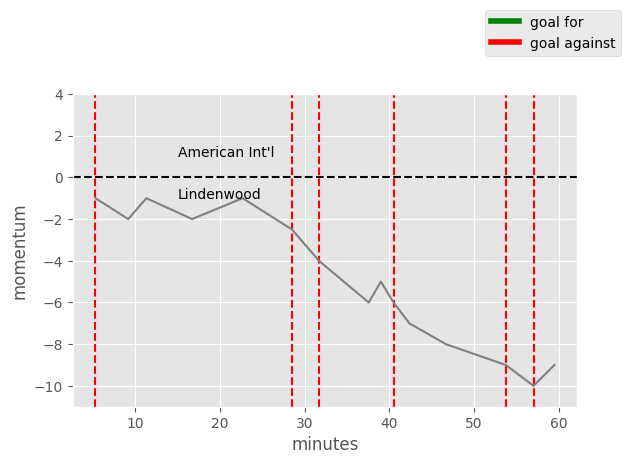

In [19]:
for target in schedule_table.team_name.unique():
  momentumplot(target)

In [72]:
### stuck hear with names etc

# maybe where this project ends?

# momentum was cool

# lots of other potential, shot outcome wasnt really looked at

# kicking back could be looked at

# momentum pattern classification?

# could this be applies to other sports? basketball might have done this already?

for n in range(0,5):
  print(pbp_table[pbp_table.events.str.contains('For')]['events'].tolist()[n].split(':')[1].lower().strip())

van eijck,cecile, tinghitella,victoria, sacker,alex, soler,maria cambra, hamm,danielle, mccrudden,jenna, washburn,sydney, strunk,patricia, florio,agustina, balachick,larissa, sarrabayrouse,maia
jemima cookson, kayla kiwak, sydney keld, arabella loveridge, anna mozeleski, jule hufer, yip van wonderen, kennedy reardon, emma thompson, maggie carter, sofia arrebola garci
amber brouwer, isabel jacobs, tina rawa, bri o'donnell, eline di leva, taylor mason, liz chipman, stephanie oleykowski, anna getty, avery powell, megan hadfield
dani van rootselaar, maura verleg, nathalie fiechter, leah crouse, sophie klautz, bibi donraadt, emma deberdine, rayne wright, hope rose, margot lawn, christina calandra
#1  dani van rootselaar, #4  maura verleg, #5  nathalie fiechter, #16 emma deberdine, #19 hope rose, #8  ericka morris-adams, #9  leah crouse, #12 bibi donraadt, #11 sophie klautz, #27 margot lawn, #77 christina calandra.


In [76]:
player_table['player_name'].str.lower().head(20)

0             borman, claire
1              schwarz, emma
2           minichello, toni
3            o'neill, evelyn
4              shirley, anna
5             mick, margaret
6          middleman, amanda
7                 coval, mia
8                albano, mia
9                       team
10          maguire, makenna
11            barsky, hannah
12         van de laar, noor
13        de ruijter, sabine
14         drakeley, shannon
15            trigg, barrett
16             voegele, cate
17    van goeverden, caitlin
18             smolij, raina
19          mitchell, meghan
Name: player_name, dtype: object